In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from multitask.etl.etl_baumgartner_suzuki import ligands, pre_catalysts
from multitask.visualization.plots import (
    make_yld_comparison_plot,
    make_categorical_comparison_plot,
    get_wandb_run_dfs,
)
from multitask.visualization.suzuki_figures import (
    reizman_case_to_name, 
    standardize_catalyst_smiles,
    catalyst_map,
)
from pathlib import Path
from summit import *
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
import wandb
import logging

In [7]:
logger = logging.getLogger(__name__)

## Baumgartner Suzuki with one Reizman Suzuki Auxiliary 

Not including STBO HS.

In [16]:
num_iterations: int = 20
num_repeats: int = 20
include_tags: Optional[List[str]] = ["EI"]
filter_tags: Optional[List[str]] = None
only_finished_runs: bool = True
wandb_entity: str = "ceb-sre"
wandb_project: str = "multitask"
figure_dir: str = "../figures"

2022-12-01 12:03:27,680 - multitask.utils - INFO - Downloading runs from wandb
2022-12-01 12:03:51,933 - multitask.utils - INFO - Downloading runs from wandb


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


2022-12-01 12:04:23,750 - multitask.utils - INFO - Downloading runs from wandb
2022-12-01 12:04:45,564 - multitask.utils - INFO - Downloading runs from wandb
2022-12-01 12:05:08,129 - multitask.utils - INFO - Downloading runs from wandb


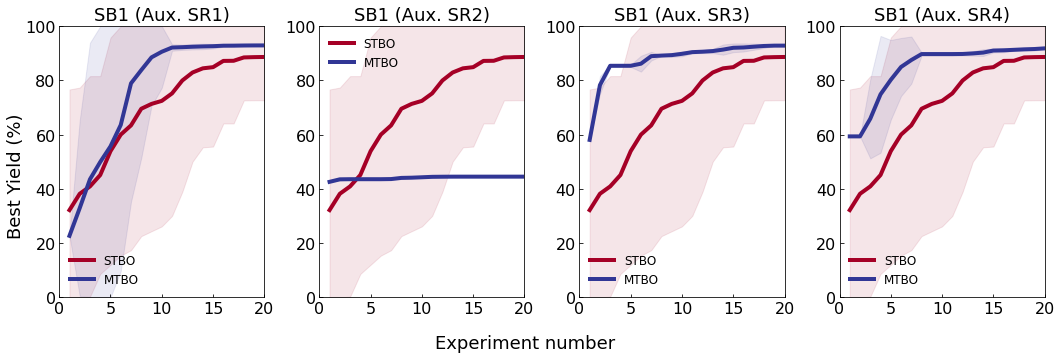

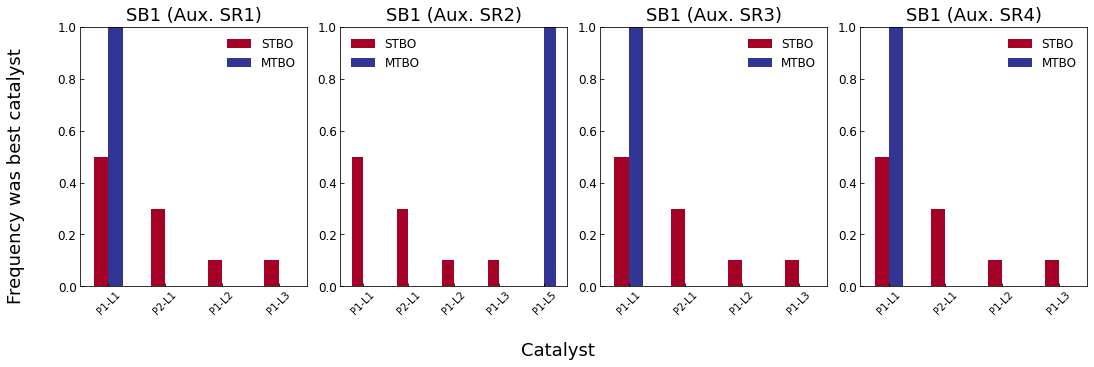

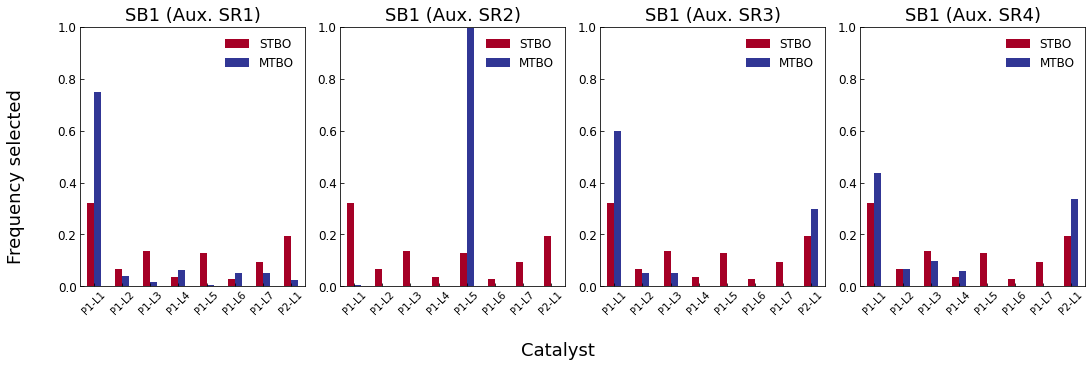

In [17]:
# Wandb API
api = wandb.Api()

# STBO downloads
logger.info("Getting Baumgartner Suzuki STBO data")
stbo_dfs = get_wandb_run_dfs(
    api,
    wandb_entity=wandb_entity,
    wandb_project=wandb_project,
    model_name="baumgartner_suzuki",
    strategy="STBO",
    include_tags=include_tags,
    filter_tags=filter_tags,
    only_finished_runs=only_finished_runs,
    num_iterations=num_iterations,
    extra_filters={"config.ct_dataset_names": []},
)
stbo_dfs = [standardize_catalyst_smiles(stbo_df) for stbo_df in stbo_dfs][
    :num_repeats
]

# Setup figure
fig_yld = plt.figure(figsize=(15, 5))
fig_yld.subplots_adjust(wspace=0.2, hspace=0.5)
fig_cat_best = plt.figure(figsize=(15, 5))
fig_cat_best.subplots_adjust(wspace=0.2, hspace=0.5)
fig_cat_counts = plt.figure(figsize=(15, 5))
fig_cat_counts.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
axis_fontsize = 16
heading_fontsize = 18
logger.info(
    "Making plots for Baumgartner Suzuki optimization with auxiliary of Reizman Suzuki"
)
for i in range(1, 5):
    # Get MTBO data
    logger.info(
        f"Getting Baumgartner Suzuki MTBO (cotrain Reizman suzuki {i}) data"
    )
    mtbo_dfs = get_wandb_run_dfs(
        api,
        wandb_entity=wandb_entity,
        wandb_project=wandb_project,
        model_name="baumgartner_suzuki",
        strategy="MTBO",
        include_tags=include_tags,
        filter_tags=filter_tags,
        only_finished_runs=only_finished_runs,
        num_iterations=num_iterations,
        extra_filters={
            "config.ct_dataset_names": [f"reizman_suzuki_case_{i}"],
        },
    )
    mtbo_dfs = [standardize_catalyst_smiles(mtbo_df) for mtbo_df in mtbo_dfs][
        :num_repeats
    ]
    # stbo_head_start_dfs = get_wandb_run_dfs(
    #     api,
    #     wandb_entity=wandb_entity,
    #     wandb_project=wandb_project,
    #     model_name="baumgartner_suzuki",
    #     strategy="STBO",
    #     include_tags=include_tags,
    #     filter_tags=filter_tags,
    #     only_finished_runs=only_finished_runs,
    #     num_iterations=num_iterations,
    #     extra_filters={
    #         "config.ct_dataset_names": [f"reizman_suzuki_case_{i}"],
    #     },
    # )
    # stbo_head_start_dfs = [
    #     standardize_catalyst_smiles(stbo_df) for stbo_df in stbo_head_start_dfs
    # ][:num_repeats]

    # Make yield comparison subplot
    ax_yld = fig_yld.add_subplot(1, 4, k)
    make_yld_comparison_plot(
        dict(results=stbo_dfs, label="STBO", color="#a50026"),
        # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
        dict(results=mtbo_dfs, label="MTBO", color="#313695"),
        output_name="yld_best",
        ax=ax_yld,
    )

    # Format subplot
    ax_yld.set_title(
        f"SB1 (Aux. {reizman_case_to_name[i]})", fontsize=heading_fontsize
    )
    ax_yld.set_xlim(0, 20)
    ax_yld.tick_params("y", labelsize=axis_fontsize)
    xlabels = np.arange(0, 21, 5)
    ax_yld.set_xticks(xlabels)
    ax_yld.set_xticklabels(xlabels, fontsize=axis_fontsize)
    ax_yld.set_ylim(0, 100)

    # Make catalyst comparison plot
    ax_cat_best = fig_cat_best.add_subplot(1, 4, k)
    make_categorical_comparison_plot(
        dict(results=stbo_dfs, label="STBO", color="#a50026"),
        # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
        dict(results=mtbo_dfs, label="MTBO", color="#313695"),
        categorical_variable="catalyst_smiles",
        output_name="yld",
        categorical_map=catalyst_map,
        ax=ax_cat_best,
        plot_type="best",
    )
    ax_cat_counts = fig_cat_counts.add_subplot(1, 4, k)
    make_categorical_comparison_plot(
        dict(results=stbo_dfs, label="STBO", color="#a50026"),
        # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
        dict(results=mtbo_dfs, label="MTBO", color="#313695"),
        categorical_variable="catalyst_smiles",
        output_name="yld",
        categorical_map=catalyst_map,
        ax=ax_cat_counts,
        plot_type="counts",
    )

    # Format subplot
    ax_cat_best.set_title(
        f"SB1 (Aux. {reizman_case_to_name[i]})", fontsize=heading_fontsize
    )
    ax_cat_best.set_ylim(0.0, 1.0)
    ax_cat_best.tick_params("y", labelsize=12, direction="in")
    ax_cat_counts.set_title(
        f"SB1 (Aux. {reizman_case_to_name[i]})", fontsize=heading_fontsize
    )
    ax_cat_counts.set_ylim(0.0, 1.0)
    ax_cat_counts.tick_params("y", labelsize=12, direction="in")
    k += 1

# Format and save figure
figure_dir = Path(figure_dir)
fig_yld.supxlabel("Experiment number", fontsize=heading_fontsize)
fig_yld.supylabel("Best Yield (%)", fontsize=heading_fontsize)
fig_yld.tight_layout()
fig_yld.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_one_cotraining_optimization.png",
    dpi=300,
    transparent=True,
)

# Catalyst best
fig_cat_best.supxlabel("Catalyst", y=-0.01, fontsize=heading_fontsize)
fig_cat_best.supylabel(
    "Frequency was best catalyst", x=-0.01, fontsize=heading_fontsize
)
fig_cat_best.tight_layout()
fig_cat_best.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_one_cotraining_optimization_catalyst_best.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

# Catalyst counts
fig_cat_counts.supxlabel("Catalyst", y=-0.01, fontsize=heading_fontsize)
fig_cat_counts.supylabel("Frequency selected", x=-0.01, fontsize=heading_fontsize)
fig_cat_counts.tight_layout()
fig_cat_counts.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_one_cotraining_optimization_catalyst_counts.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)
logger.info("Plots saved to %s", figure_dir)

In [22]:
for ax in fig_cat_counts.axes:
    ax.xaxis.set_tick_params(labelsize=axis_fontsize)
    ax.yaxis.set_tick_params(labelsize=axis_fontsize)

In [23]:
fig_cat_counts.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_one_cotraining_optimization_catalyst_counts.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

## Baumgartner Suzuki with all Reizman Suzuki Auxiliary 

Not including STBO HS.

In [24]:
num_iterations: int = 20
num_repeats: int = 20
include_tags: Optional[List[str]] = ["EI"]
filter_tags: Optional[List[str]] = None
only_finished_runs: bool = True
wandb_entity: str = "ceb-sre"
wandb_project: str = "multitask"
figure_dir: str = "../figures"

2022-12-01 12:16:30,195 - multitask.utils - INFO - Downloading runs from wandb
2022-12-01 12:16:48,393 - multitask.utils - INFO - Downloading runs from wandb


AttributeError: 'Figure' object has no attribute 'set_xlabel'

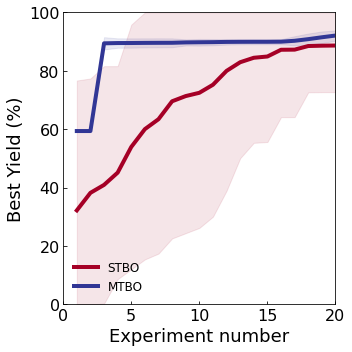

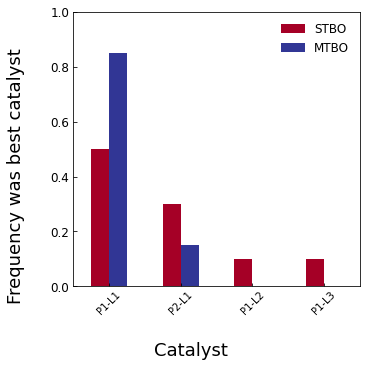

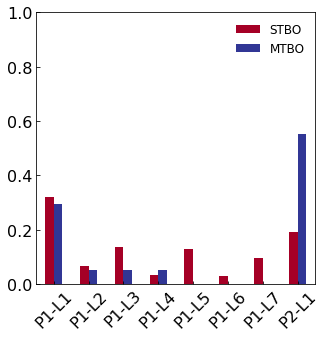

In [28]:
# Wandb API
api = wandb.Api()

# STBO downloads
logger.info("Getting Baumgartner Suzuki STBO data")
stbo_dfs = get_wandb_run_dfs(
    api,
    wandb_entity=wandb_entity,
    wandb_project=wandb_project,
    model_name="baumgartner_suzuki",
    strategy="STBO",
    include_tags=include_tags,
    filter_tags=filter_tags,
    only_finished_runs=only_finished_runs,
    num_iterations=num_iterations,
    extra_filters={"config.ct_dataset_names": []},
)
stbo_dfs = [standardize_catalyst_smiles(stbo_df) for stbo_df in stbo_dfs][
    :num_repeats
]

# Setup figure
fig_yld, ax_yld = plt.subplots(1, figsize=(5, 5))
fig_cat_best, ax_cat_best = plt.subplots(1, figsize=(5, 5))
fig_cat_counts, ax_cat_counts = plt.subplots(1, figsize=(5, 5))
axis_fontsize = 16
heading_fontsize = 18
logger.info(
    "Making plot for Baumgartner Suzuki optimization with auxiliary of Reizman Suzuki"
)
# Get MTBO data
logger.info(f"Getting Baumgartner Suzuki MTBO (cotrain all Reizman Suzuki) data")
mtbo_dfs = get_wandb_run_dfs(
    api,
    wandb_entity=wandb_entity,
    wandb_project=wandb_project,
    model_name="baumgartner_suzuki",
    strategy="MTBO",
    include_tags=include_tags,
    filter_tags=filter_tags,
    only_finished_runs=only_finished_runs,
    num_iterations=num_iterations,
    extra_filters={
        "config.ct_dataset_names": [
            f"reizman_suzuki_case_{j}" for j in range(1, 5)
        ],
    },
)
mtbo_dfs = [standardize_catalyst_smiles(mtbo_df) for mtbo_df in mtbo_dfs][
    :num_repeats
]
# stbo_head_start_dfs = get_wandb_run_dfs(
#     api,
#     wandb_entity=wandb_entity,
#     wandb_project=wandb_project,
#     model_name="baumgartner_suzuki",
#     strategy="STBO",
#     include_tags=include_tags,
#     filter_tags=filter_tags,
#     only_finished_runs=only_finished_runs,
#     # num_iterations=num_iterations,
#     extra_filters={
#         "config.ct_dataset_names": [
#             f"reizman_suzuki_case_{j}" for j in range(1, 5)
#         ],
#     },
# )
# stbo_head_start_dfs = [
#     standardize_catalyst_smiles(stbo_df) for stbo_df in stbo_head_start_dfs
# ][:num_repeats]

# Make comparison subplot
make_yld_comparison_plot(
    dict(results=stbo_dfs, label="STBO", color="#a50026"),
    # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
    dict(results=mtbo_dfs, label="MTBO", color="#313695"),
    output_name="yld_best",
    ax=ax_yld,
)

# Format subplot
ax_yld.set_xlim(0, 20)
ax_yld.tick_params("y", labelsize=axis_fontsize)
xlabels = np.arange(0, 21, 5)
ax_yld.set_xticks(xlabels)
ax_yld.set_xticklabels(xlabels, fontsize=axis_fontsize)
ax_yld.set_ylim(0, 100)

# Categorical plots
make_categorical_comparison_plot(
    dict(results=stbo_dfs, label="STBO", color="#a50026"),
    # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
    dict(results=mtbo_dfs, label="MTBO", color="#313695"),
    categorical_variable="catalyst_smiles",
    output_name="yld",
    categorical_map=catalyst_map,
    ax=ax_cat_best,
    plot_type="best",
)
make_categorical_comparison_plot(
    dict(results=stbo_dfs, label="STBO", color="#a50026"),
    # dict(results=stbo_head_start_dfs, label="STBO HS", color="#FDAE61"),
    dict(results=mtbo_dfs, label="MTBO", color="#313695"),
    categorical_variable="catalyst_smiles",
    output_name="yld",
    categorical_map=catalyst_map,
    ax=ax_cat_counts,
    plot_type="counts",
)

# Format subplot
ax_cat_best.set_ylim(0.0, 1.0)
ax_cat_best.tick_params("y", labelsize=12, direction="in")
ax_cat_counts.set_ylim(0.0, 1.0)
ax_cat_counts.tick_params("y", labelsize=12, direction="in")

# Format and save figure
ax_yld.set_xlabel("Experiment number", fontsize=heading_fontsize)
ax_yld.set_ylabel("Best Yield (%)", fontsize=heading_fontsize)
fig_yld.tight_layout()
figure_dir = Path(figure_dir)
fig_yld.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_all_cotraining_optimization.png",
    dpi=300,
    transparent=True,
)

# Catalyst best
fig_cat_best.supxlabel("Catalyst", y=-0.01, fontsize=heading_fontsize)
fig_cat_best.supylabel(
    "Frequency was best catalyst", x=-0.01, fontsize=heading_fontsize
)
fig_cat_best.tight_layout()
fig_cat_best.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_all_cotraining_optimization_catalyst_best.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

# Catalyst counts


In [31]:
for ax in fig_cat_counts.axes:
    ax.xaxis.set_tick_params(labelsize=axis_fontsize)
    ax.yaxis.set_tick_params(labelsize=axis_fontsize)
ax_cat_counts.set_xlabel("Catalyst", fontsize=heading_fontsize)
ax_cat_counts.set_ylabel("Frequency selected",fontsize=heading_fontsize)
ax.set_ylim(0.0, 0.6)
# fig_cat_counts.tight_layout()
fig_cat_counts.savefig(
    figure_dir
    / "baumgartner_suzuki_reizman_suzuki_all_cotraining_optimization_catalyst_counts.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)
logger.info("Plots saved to %s", figure_dir)